58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

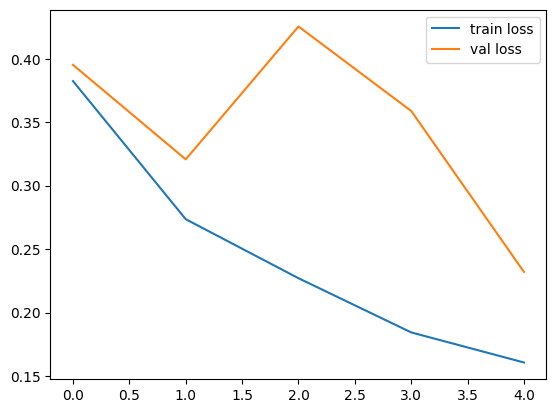

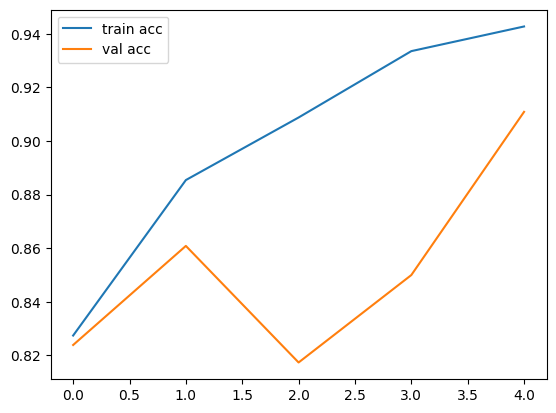

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<Figure size 640x480 with 0 Axes>

In [ ]:


from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'training_path_of_your_dataset'
valid_path = 'validation_path_of_your_dataset'

# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

# useful for getting number of classes
folders = glob(train_path + '/*')

# our layers - you can add more if you want
x = Flatten()(vgg.output)
# Add a fully connected layer with sigmoid activation for binary classification
prediction = Dense(1, activation='sigmoid')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'binary')

# fit the model
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

import tensorflow as tf
from keras.models import load_model

model.save('damage_or_whole_preliminary_model.h5')


In [ ]:
from keras.models import load_model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
import json

# Load the model obtained from the previous code
model = load_model('damage_or_whole_preliminary_model.h5')

# Unfreeze some layers of the VGG16 model
for layer in model.layers[15:]:
    layer.trainable = True

# Compile the model with a new optimizer and a low learning rate
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define paths to your training and validation datasets
train_path = 'training_path_of_your_dataset'
valid_path = 'validation_path_of_your_dataset'

# Define batch size and number of epochs for fine-tuning
batch_size = 32
epochs = 5

# Set up data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 batch_size=batch_size,
                                                 class_mode='binary')

test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size=(224, 224),
                                            batch_size=batch_size,
                                            class_mode='binary')

# Define callbacks, e.g., to save the best model during training
checkpoint = ModelCheckpoint('damage_whole.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# Fine-tune the model
history = model.fit(training_set,
                    steps_per_epoch=len(training_set),
                    epochs=epochs,
                    validation_data=test_set,
                    validation_steps=len(test_set),
                    callbacks=[checkpoint])

# Save the training history
with open('fine_tuning_history.json', 'w') as f:
    json.dump(history.history, f)

# Evaluate the fine-tuned model
evaluation = model.evaluate(test_set, steps=len(test_set))
print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy:", evaluation[1])


Found 1414 images belonging to 2 classes.
Found 460 images belonging to 2 classes.
Epoch 1/5
45/45 [==============================] - ETA: 0s - loss: 2.6219 - accuracy: 0.6521 
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to fine_tuned_model.h5
45/45 [==============================] - 1428s 32s/step - loss: 2.6219 - accuracy: 0.6521 - val_loss: 0.6982 - val_accuracy: 0.5000
Epoch 2/5
45/45 [==============================] - ETA: 0s - loss: 0.6475 - accuracy: 0.6697 
Epoch 2: val_accuracy did not improve from 0.50000
45/45 [==============================] - 1384s 31s/step - loss: 0.6475 - accuracy: 0.6697 - val_loss: 0.7307 - val_accuracy: 0.5000
Epoch 3/5
45/45 [==============================] - ETA: 0s - loss: 0.6356 - accuracy: 0.6697 
Epoch 3: val_accuracy did not improve from 0.50000
45/45 [==============================] - 1379s 31s/step - loss: 0.6356 - accuracy: 0.6697 - val_loss: 0.7451 - val_accuracy: 0.5000
Epoch 4/5
45/45 [==============================]

In [ ]:
from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img
import numpy as np

# Load the fine-tuned model
fine_tuned_model = load_model('location_of/damage_whole.h5')

# Function to preprocess a single image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))  # Assuming input size is 224x224
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale pixel values to [0, 1]
    return img_array

# Function to classify a single image
def classify_single_image(image_path):
    preprocessed_img = preprocess_image(image_path)
    prediction = fine_tuned_model.predict(preprocessed_img)
    print(prediction[0][0])
    prediction[0][0]
    if prediction[0][0] < 0.5:
        return 0  # Damaged
    else:
        return 1  # Whole

# Path of the single input image to classify
input_image_path = 'input_image_path'

# Classify the single input image
result = classify_single_image(input_image_path)

# Print the result
if result == 0:
    print("The image is classified as damaged.")
else:
    print("The image is classified as whole.")


1/1 [==============================] - 1s 1s/step
0.99417156
The image is classified as whole.
